# Single Stock

### Github Package
* https://github.com/hill-a/stable-baselines
* https://github.com/openai/gym
* https://github.com/jealous/stockstats

In [3]:
# !pip install stable-baselines
# !pip install gym
# !pip install stockstats

In [1]:
import warnings
import sys

if not sys.warnoptions:
    warnings.simplefilter("ignore")
import gym

from stable_baselines import SAC
from stable_baselines import PPO2
from stable_baselines import A2C
from stable_baselines import DDPG
from stable_baselines import TD3
from stable_baselines.ddpg.policies import DDPGPolicy
from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise, AdaptiveParamNoiseSpec
from stable_baselines.common.vec_env import DummyVecEnv
from env.StockTradingRLEnvSingleStock import StockEnv

#import json
#import datetime as dt
import pandas as pd
import numpy as np
import time

from stockstats import StockDataFrame as Sdf
from sklearn import preprocessing
#import pickle

In [19]:
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
# edit environment
import env.StockTradingRLEnvSingleStock
from importlib import reload

reload(env.StockTradingRLEnvSingleStock)
from env.StockTradingRLEnvSingleStock import StockEnv

## Data Preprocessing

In [4]:
# import file path
filename = 'data/wrds_etf_2020.csv'

In [5]:
choose_stock = ['SPY','QQQ','DIA']

In [6]:
def preprocess_data(filename, choose_stock):
    df_2020 = pd.read_csv(filename)
    # only take the columns we want
    df_2020=df_2020[['datadate','tic','prccd','ajexdi','prcod','prchd','prcld','cshtrd']]
    # filter stocks
    #choose_stock = ['SPY','QQQ','DIA']
    df_2020_2 = df_2020[df_2020.tic.isin(choose_stock)]
    # check if all the stocks have the same data length (very important)
    df_2020_2[df_2020_2.datadate>=20090000].tic.value_counts()
    df_2020_3 = df_2020_2[df_2020_2.datadate>=20090000]
    def calcualte_price(df):
        """
        calcualte adjusted close price, open-high-low price and volume
        :param data: (df) pandas dataframe
        :return: (df) pandas dataframe
        """
        data_3=df.copy()
        data_3 = data_3[['datadate','tic','prccd','ajexdi','prcod','prchd','prcld','cshtrd']]
        data_3['ajexdi']=data_3['ajexdi'].apply(lambda x: 1 if x==0 else x)

        data_3['adjcp'] = data_3['prccd'] / data_3['ajexdi']
        data_3['open'] = data_3['prcod'] / data_3['ajexdi']
        data_3['high'] = data_3['prchd'] / data_3['ajexdi']
        data_3['low'] = data_3['prcld'] / data_3['ajexdi']
        data_3['volume'] = data_3['cshtrd'] 

        data_3=data_3[['datadate','tic','adjcp','open','high','low','volume']]
        data_3 = data_3.sort_values(['tic','datadate'],ignore_index=True)
        return data_3
    df_preprocess = calcualte_price(df_2020_3)

    def add_technical_indicator(df):
        """
        calcualte technical indicators
        :param data: (df) pandas dataframe
        :return: (df) pandas dataframe
        """
        stock = Sdf.retype(df.copy())

        stock['close'] = stock['adjcp']
        unique_ticker = stock.tic.unique()

        macd = pd.DataFrame()
        rsi = pd.DataFrame()
        cci = pd.DataFrame()
        dx = pd.DataFrame()

        #temp = stock[stock.tic == unique_ticker[0]]['macd']
        for i in range(len(unique_ticker)):
            ## macd
            temp_macd = stock[stock.tic == unique_ticker[i]]['macd']
            temp_macd = pd.DataFrame(temp_macd)
            macd = macd.append(temp_macd,ignore_index=True)
            ## rsi
            temp_rsi = stock[stock.tic == unique_ticker[i]]['rsi_30']
            temp_rsi = pd.DataFrame(temp_rsi)
            rsi = rsi.append(temp_rsi,ignore_index=True)     
            ## cci
            temp_cci = stock[stock.tic == unique_ticker[i]]['cci_30']
            temp_cci = pd.DataFrame(temp_cci)
            cci = cci.append(temp_cci,ignore_index=True)        
            ## adx
            temp_dx = stock[stock.tic == unique_ticker[i]]['dx_30']
            temp_dx = pd.DataFrame(temp_dx)
            dx = dx.append(temp_dx,ignore_index=True)        


        df['macd'] = macd
        df['rsi'] = rsi    
        df['cci'] = cci        
        df['adx'] = dx        

        return df
    df_final=add_technical_indicator(df_preprocess)
    df_final.fillna(method='bfill',inplace=True)
    return df_final

In [7]:
df_final = preprocess_data(filename, choose_stock)

NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values
NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values
NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


In [8]:
df_final_tvix = preprocess_data(filename, ['TVIX'])

NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


In [9]:
df_final.head()

,datadate,tic,adjcp,open,high,low,volume,macd,rsi,cci,adx
0,20090102,DIA,90.20,87.95,90.62,87.57,24563770.0,0.000000,0.000000,66.666667,100.000000
1,20090105,DIA,89.70,89.87,90.33,88.87,25611230.0,-0.011218,0.000000,66.666667,100.000000
2,20090106,DIA,90.15,90.18,90.90,89.38,37258790.0,-0.000339,48.214286,100.000000,100.000000
3,20090107,DIA,87.86,88.88,89.18,87.23,33164670.0,-0.078063,13.626871,-133.333333,60.254869
4,20090108,DIA,87.43,87.07,87.57,86.55,23640660.0,-0.135764,11.960243,-113.173600,68.726881


In [10]:
unique_date = df_final.datadate.unique()

In [11]:
len(unique_date)

2886

In [12]:
df_final.head()

,datadate,tic,adjcp,open,high,low,volume,macd,rsi,cci,adx
0,20090102,DIA,90.20,87.95,90.62,87.57,24563770.0,0.000000,0.000000,66.666667,100.000000
1,20090105,DIA,89.70,89.87,90.33,88.87,25611230.0,-0.011218,0.000000,66.666667,100.000000
2,20090106,DIA,90.15,90.18,90.90,89.38,37258790.0,-0.000339,48.214286,100.000000,100.000000
3,20090107,DIA,87.86,88.88,89.18,87.23,33164670.0,-0.078063,13.626871,-133.333333,60.254869
4,20090108,DIA,87.43,87.07,87.57,86.55,23640660.0,-0.135764,11.960243,-113.173600,68.726881


In [13]:
#final_columns = df_final.columns

In [39]:
#df_final.to_csv('data/etf_spy_dia_qqq_2020.csv',index=False)

In [40]:
#df_final = pd.read_csv('data/etf_spy_dia_qqq_2020.csv')

## Train & Test split

In [13]:
def data_split(df_final,start,end):
    data = df_final[(df_final.datadate > start) & (df_final.datadate < end)]
    data=data.sort_values(['datadate','tic'],ignore_index=True)
    #data  = data[final_columns]
    data.index = data.datadate.factorize()[0]
    return data

In [14]:
train_2017 = data_split(df_final,start = 20090000,end=20170000)
test_2020  = data_split(df_final,start = 20170000,end=20200200)

In [15]:
train_2009_2016_spy = train_2017[train_2017.tic=='SPY']
test_2017_2020_spy = test_2020[test_2020.tic=='SPY']

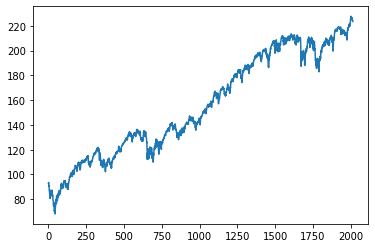

In [20]:
train_2009_2016_spy.adjcp.plot()

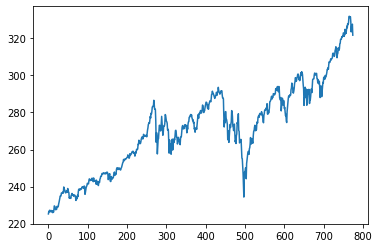

In [21]:
test_2017_2020_spy.adjcp.plot()

In [22]:
train_2009_2016_dia = train_2017[train_2017.tic=='DIA']
test_2017_2020_dia = test_2020[test_2020.tic=='DIA']

In [72]:
def calcualte_sharpe(adjcp):
    print((252**0.5)*adjcp.pct_change(1).mean()/adjcp.pct_change(1).std())

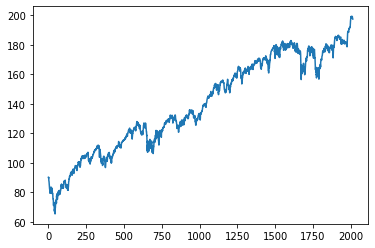

In [23]:
train_2009_2016_dia.adjcp.plot()

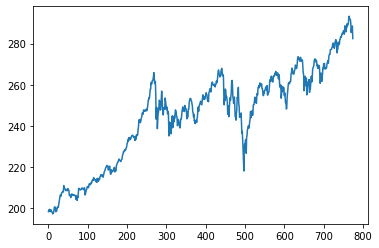

In [24]:
test_2017_2020_dia.adjcp.plot()

In [73]:
calcualte_sharpe(test_2017_2020_dia.adjcp)

0.9393360617092317


In [25]:
train_2009_2016_qqq = train_2017[train_2017.tic=='QQQ']
test_2017_2020_qqq = test_2020[test_2020.tic=='QQQ']

In [ ]:
 df_total_value['daily_return']=df_total_value.pct_change(1)
            sharpe = (252**0.5)*df_total_value['daily_return'].mean()/ \
                  df_total_value['daily_return'].std()

In [74]:
calcualte_sharpe(test_2017_2020_qqq.adjcp)

1.2324282123483696


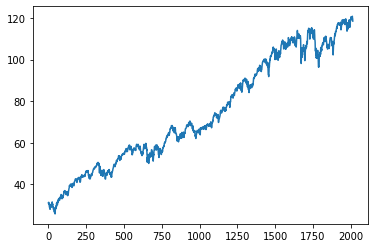

In [54]:
train_2009_2016_qqq.adjcp.plot()

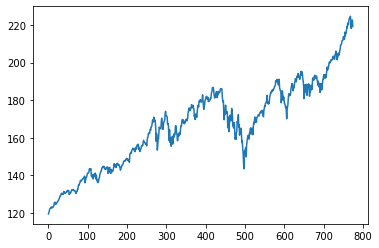

In [55]:
test_2017_2020_qqq.adjcp.plot()

In [28]:
df_final_tvix.head()

,datadate,tic,adjcp,open,high,low,volume,macd,rsi,cci,adx
0,20101130,TVIX,112.35,106.27,112.35,104.3900,47900.0,0.000000,0.0,-66.666667,100.0
1,20101201,TVIX,100.69,99.98,100.69,98.8000,38300.0,-0.261603,0.0,-66.666667,100.0
2,20101202,TVIX,86.59,98.31,98.31,86.5000,7575.0,-0.770574,0.0,-99.849885,100.0
3,20101203,TVIX,78.78,88.36,88.36,78.1240,2848.0,-1.265156,0.0,-97.613508,100.0
4,20101206,TVIX,75.69,79.77,80.00,74.6201,8445.0,-1.630228,0.0,-95.081405,100.0


In [29]:
train_2018_tvix = data_split(df_final_tvix,start = 20090000,end=20180000)
test_2020_tvix  = data_split(df_final_tvix,start = 20180000,end=20200200)

In [75]:
calcualte_sharpe(test_2020_tvix.adjcp)

-0.12541406977224878


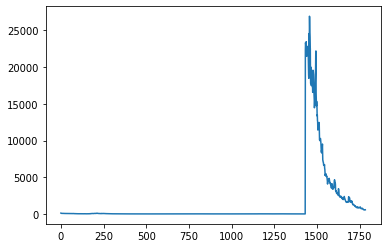

In [30]:
train_2018_tvix.adjcp.plot()

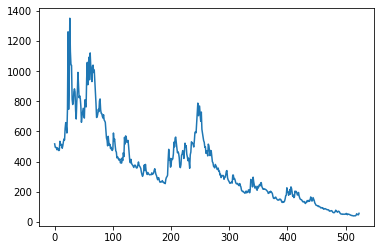

In [31]:
test_2020_tvix.adjcp.plot()

In [32]:
train_2009_2016_spy.head()

,datadate,tic,adjcp,open,high,low,volume,macd,rsi,cci,adx
0,20090102,SPY,92.960,90.44,93.4400,89.85,227563000.0,0.000000,0.000000,66.666667,100.000000
1,20090105,SPY,92.850,92.63,94.5533,91.89,240076500.0,-0.002468,0.000000,66.666667,100.000000
2,20090106,SPY,93.470,93.64,94.4500,92.68,327996400.0,0.016082,85.360257,76.511166,100.000000
3,20090107,SPY,90.670,92.00,92.2600,90.20,280574700.0,-0.076969,17.113433,-106.235594,43.589885
4,20090108,SPY,91.042,90.16,91.0900,89.67,263579600.0,-0.111108,25.319620,-98.092589,51.538298


In [33]:
def DRL_trading(model, test_data, test_env, test_obs):
    start = time.time()
    #we can directly load a pretrained model
    #model_a2c=A2C.load('model_single_stock/a2c_200k_all_tcost_best')
    for i in range(len(test_data.index.unique())):    
        action, _states = model.predict(test_obs)
        test_obs, rewards, dones, info = test_env.step(action)
        #env_test.render()
    end = time.time()
    

## Environment Setup
* The algorithms require a vectorized environment to run

In [34]:
## SPY
env_train_spy = DummyVecEnv([lambda: StockEnv(train_2009_2016_spy)])
env_test_spy = DummyVecEnv([lambda: StockEnv(test_2017_2020_spy)])
obs_spy = env_test_spy.reset()

In [53]:
## DIA
env_train_dia = DummyVecEnv([lambda: StockEnv(train_2009_2016_dia)])
env_test_dia = DummyVecEnv([lambda: StockEnv(test_2017_2020_dia)])
obs_dia = env_test_dia.reset()

In [56]:
## QQQ
env_train_qqq = DummyVecEnv([lambda: StockEnv(train_2009_2016_qqq)])
env_test_qqq = DummyVecEnv([lambda: StockEnv(test_2017_2020_qqq)])
obs_qqq = env_test_qqq.reset()

In [35]:
## TVIX
env_train_tvix = DummyVecEnv([lambda: StockEnv(train_2018_tvix)])
env_test_tvix = DummyVecEnv([lambda: StockEnv(test_2020_tvix)])
obs_tvix = env_test_tvix.reset()

### A2C

In [36]:
def train_A2C(env_train, model_save_path):
    start = time.time()
    model_a2c = A2C('MlpPolicy', env_train, verbose=0)
    model_a2c.learn(100000)
    end = time.time()
    model_a2c.save(model_save_path)
    print((end-start)/60,' minutes')
    return model_a2c

### Training

In [37]:
## SPY
model_a2c_spy = train_A2C(env_train_spy,"model_single_stock/a2c_100k_spy")

total_reward:51489.40299701854
total_cost:  3925.106229415746
Sharpe:  0.503423003376638
total_reward:133166.16151402588
total_cost:  4044.798679828398
Sharpe:  0.55676301539341
total_reward:335731.12086564023
total_cost:  4210.638939736042
Sharpe:  0.5208307244531495
total_reward:526351.0913216141
total_cost:  4060.821781644773
Sharpe:  0.6441108190291217
total_reward:730324.0194850846
total_cost:  3684.4467967317664
Sharpe:  0.7205241818233804
total_reward:794223.1101092207
total_cost:  3987.2014308325747
Sharpe:  0.7365882197780947
total_reward:745836.8304290462
total_cost:  3734.1870185623425
Sharpe:  0.7236023548228504
total_reward:555196.7467355481
total_cost:  3947.9583157506695
Sharpe:  0.6488874721723589
total_reward:800701.2173493118
total_cost:  4063.9689848224416
Sharpe:  0.7392780211910911
total_reward:796477.3584975973
total_cost:  3383.471165686354
Sharpe:  0.7297638284545525
total_reward:722369.9200034991
total_cost:  3027.0301453942748
Sharpe:  0.7245982089551917
total

KeyboardInterrupt: 

In [57]:
## DIA
model_a2c_dia = train_A2C(env_train_dia,"model_single_stock/a2c_100k_dia")

total_reward:19118.677694884944
total_cost:  3344.0037352086247
Sharpe:  0.5405981410450289
total_reward:2448.3835527200717
total_cost:  3121.950121199337
Sharpe:  0.18651595651777894
total_reward:32829.780418902985
total_cost:  3411.1357033037916
Sharpe:  0.4220934362746882
total_reward:12384.001492792508
total_cost:  3386.111057596298
Sharpe:  0.48297786734346326
total_reward:20837.805605155998
total_cost:  3391.9283968694112
Sharpe:  0.35885477216036693
total_reward:14137.321585159982
total_cost:  3100.7664952033892
Sharpe:  0.38334684168190375
total_reward:85056.02871418698
total_cost:  3484.114884568235
Sharpe:  0.46275319579255914
total_reward:54853.80928723095
total_cost:  3335.5807684790752
Sharpe:  0.6465945060717162
total_reward:237871.98242436838
total_cost:  3628.735514064263
Sharpe:  0.5791038162993638
total_reward:196952.14854789944
total_cost:  3637.4378035835775
Sharpe:  0.613758049390474
total_reward:20751.507067819708
total_cost:  3488.344114737372
Sharpe:  0.36028152

In [60]:
## QQQ
model_a2c_qqq = train_A2C(env_train_qqq,"model_single_stock/a2c_100k_qqq")

total_reward:8606.809082269436
total_cost:  1809.6625817607608
Sharpe:  0.5613785291356848
total_reward:9680.899460418965
total_cost:  1715.2769775947338
Sharpe:  0.40576562639470326
total_reward:113716.86448629783
total_cost:  1973.5423402773806
Sharpe:  0.4567795152706983
total_reward:19275.812539042323
total_cost:  1685.14914657257
Sharpe:  0.5819582808032419
total_reward:78363.04807032458
total_cost:  1841.5272523312055
Sharpe:  0.5314587306560044
total_reward:196082.92863848712
total_cost:  1893.0572016021933
Sharpe:  0.732425378733632
total_reward:372826.1313262768
total_cost:  2322.4338756548973
Sharpe:  0.5939476230409485
total_reward:418262.1017721698
total_cost:  1993.7642828608716
Sharpe:  0.7359116118770986
total_reward:325990.18610309507
total_cost:  1962.5062470572293
Sharpe:  0.6710683292862135
total_reward:219977.81923000002
total_cost:  1955.566884147022
Sharpe:  0.5971914457610229
total_reward:362229.84729074873
total_cost:  1989.7431844936295
Sharpe:  0.6814153182186

In [38]:
## TVIX
model_a2c_tvix = train_A2C(env_train_tvix,"model_single_stock/a2c_100k_tvix")

total_reward:-794885.1552156155
total_cost:  29341.07993657787
Sharpe:  -0.17459315697291283
total_reward:427147.26645260537
total_cost:  24361.784935351105
Sharpe:  0.35568196393746093
total_reward:3139072.8431193368
total_cost:  31624.20921243
Sharpe:  0.3649999157430027
total_reward:-13744.166846130742
total_cost:  446.50998239225567
Sharpe:  -0.44611757310723
total_reward:-13861.88684860291
total_cost:  406.17647569977044
Sharpe:  -0.38160030568266634
total_reward:70595.27092608041
total_cost:  3056.7839569989496
Sharpe:  0.25713636397501094
total_reward:-678.9995052330196
total_cost:  45.46461798257542
Sharpe:  -0.3856129395742353
total_reward:-2371.0604021097533
total_cost:  100.32585608841323
Sharpe:  -0.3922096479598677
total_reward:-2889.201483710436
total_cost:  120.59224320459366
Sharpe:  -0.3915708537134094
total_reward:-21.033870738814585
total_cost:  2.7236771491050717
Sharpe:  -0.09224911413015485
total_reward:-1288.9757018142845
total_cost:  27.76357271118164
Sharpe:  -

KeyboardInterrupt: 

### Trading

In [128]:
## need to manually locate the account_value.csv 
## and rename it based on different models
## A2C

In [131]:
## SPY
DRL_trading(model_a2c_spy, test_2017_2020_spy, env_test_spy, obs_spy)

total_reward:261222.5737999999
total_cost:  1995.9262000000003
Sharpe:  0.7110783431455031


In [59]:
## DIA
DRL_trading(model_a2c_dia, test_2017_2020_dia, env_test_dia, obs_dia)

total_reward:219111.28792168642
total_cost:  2011.4514286930767
Sharpe:  0.6172757482816066


In [62]:
## QQQ
DRL_trading(model_a2c_qqq, test_2017_2020_qqq, env_test_qqq, obs_qqq)

total_reward:370090.46528000105
total_cost:  1995.9547199999986
Sharpe:  0.8907979106652928


In [138]:
## TVIX
DRL_trading(model_a2c_tvix, test_2020_tvix, env_test_tvix, obs_tvix)

total_reward:-2268.3165056693833
total_cost:  227.98218885803217
Sharpe:  -0.5386748191363985


## DDPG

In [ ]:
def train_DDPG(env_train, model_save_path):
    start = time.time()
    model_ddpg = DDPG('MlpPolicy', env_train)
    model_ddpg.learn(total_timesteps=10000)
    end = time.time()
    model_ddpg.save(model_save_path)
    print((end-start)/60,' minutes')
    #10mins for 100k
    return model_ddpg

### Training

In [ ]:
## training
model_ddpg_spy = train_DDPG(env_train_spy,"model_single_stock/ddpg_10k_spy")

In [114]:
## training
model_ddpg_tvix = train_DDPG(env_train_tvix,"model_single_stock/ddpg_10k_tvix")

total_reward:-15.552247385377996
total_cost:  0.3657712304059269
Sharpe:  -0.3055476549106426
total_reward:0.0
total_cost:  0
Sharpe:  nan
total_reward:1830.8393144693691
total_cost:  219.0403136148756
Sharpe:  0.1646012861588513
total_reward:-202588.17970392876
total_cost:  8574.31515133924
Sharpe:  -0.36070131535637306
total_reward:37353.590978866094
total_cost:  2082.677393442028
Sharpe:  0.1939999212121443
total_reward:36047.95862112963
total_cost:  2052.778447111419
Sharpe:  0.18512943469345208
DDPG:  0.6303281863530477  minutes


### Trading

In [118]:
## TVIX
DRL_trading(model_a2c_tvix, test_2020_tvix, env_test_tvix, obs_tvix)

total_reward:-21378.663253635284
total_cost:  1450.3457623460008
Sharpe:  -0.42982506298545536


In [ ]:
DRL_trading(model_ddpg, test_2020_tvix, env_test_tvix, obs_tvix)

In [ ]:
DRL_trading(model_ddpg, test_2020_tvix, env_test_tvix, obs_tvix)

## PPO

In [48]:
def train_PPO(env_train, model_save_path):
    start = time.time()
    model_ppo = PPO2('MlpPolicy', env_train)
    model_ppo.learn(100000)
    end = time.time()
    model_ppo.save(model_save_path)
    print((end-start)/60,' minutes')
    return model_ppo

### Training

In [ ]:
## SPY
model_ppo_spy = train_A2C(env_train_spy,"model_single_stock/ppo_100k_spy")

In [63]:
## QQQ
model_ppo_qqq = train_PPO(env_train_qqq,"model_single_stock/ppo_100k_qqq")

total_reward:34346.96352104598
total_cost:  1889.3345727558158
Sharpe:  0.4950576106723653
total_reward:126144.52430175757
total_cost:  1993.638578682702
Sharpe:  0.6027784353658542
total_reward:136975.56170395948
total_cost:  1956.284521394372
Sharpe:  0.6056631113145428
total_reward:287917.60177806206
total_cost:  1981.3793371827078
Sharpe:  0.6799718521957038
total_reward:247584.046273557
total_cost:  1986.1534468782131
Sharpe:  0.6443980432194513
total_reward:339332.7852860112
total_cost:  2026.1193735208224
Sharpe:  0.663109160286797
total_reward:310230.77478044573
total_cost:  2018.5491577835196
Sharpe:  0.6848293115044333
total_reward:302347.9324287635
total_cost:  2005.0429844218395
Sharpe:  0.651344463676247
total_reward:339887.01609096536
total_cost:  2036.2485602231984
Sharpe:  0.6678878932600771
total_reward:288566.76607199013
total_cost:  2019.5515352461703
Sharpe:  0.6508229096741228
total_reward:294348.7818339581
total_cost:  2003.2858884561963
Sharpe:  0.652252430329669

In [49]:
## TVIX
model_ppo_tvix = train_PPO(env_train_tvix,"model_single_stock/ppo_100k_tvix")

total_reward:-71312.88480762392
total_cost:  29289.19615721696
Sharpe:  0.24343955423429292
total_reward:564068.6357875199
total_cost:  27586.325237768066
Sharpe:  0.2821185820347363
total_reward:-138545.86399562913
total_cost:  11741.476926585916
Sharpe:  -0.6654819802486355
total_reward:-129916.7080416244
total_cost:  10373.945712152114
Sharpe:  -0.5934441606447102
total_reward:-93810.63808482117
total_cost:  14442.168385195058
Sharpe:  -0.14417540782775018
total_reward:-227857.6570701223
total_cost:  14336.945715878332
Sharpe:  -0.5690205112052229
total_reward:-78755.11431676499
total_cost:  7683.105907425718
Sharpe:  -0.832151153564373
total_reward:18127.595225698547
total_cost:  3683.428948722228
Sharpe:  0.27713616907004834
total_reward:179973.75125702587
total_cost:  4007.331678898259
Sharpe:  0.3144871248108904
total_reward:4112.4577819939
total_cost:  5453.968361922368
Sharpe:  0.05456731513993654
total_reward:-73034.57106650574
total_cost:  9191.854630426911
Sharpe:  -0.71816

### Trading

In [ ]:
## SPY
#model_ppo_spy=PPO2.load('model_single_stock/ppo_100k_spy')
DRL_trading(model_ppo_spy, test_2017_2020_spy, env_test_spy, obs_spy)

In [65]:
## QQQ
DRL_trading(model_ppo_qqq, test_2017_2020_qqq, env_test_qqq, obs_qqq)

total_reward:342449.8009348158
total_cost:  2219.7632030867567
Sharpe:  0.9069735687580246


In [52]:
## TVIX
DRL_trading(model_ppo_tvix, test_2020_tvix, env_test_tvix, obs_tvix)

total_reward:-6.056430398137309
total_cost:  9.241864632606505
Sharpe:  -0.021424089504709035


## SAC

In [139]:
# env setup
## Training Environment
# The algorithms require a vectorized environment to run
env_train_spy = DummyVecEnv([lambda: StockEnv(train_2009_2016_spy)])
env_test_spy = DummyVecEnv([lambda: StockEnv(test_2017_2020_spy)])
obs_spy = env_test_spy.reset()


In [141]:
start = time.time()
model_sac = SAC('MlpPolicy', env_train_spy, verbose=0)
model_sac.learn(10000)
end = time.time()
model_ppo.save("model_single_stock/sac_10k_spy")
print('sac: ',(end-start)/60,' minutes')

total_reward:858470.124652192
total_cost:  2048.443978607822
Sharpe:  0.7246704155502058
total_reward:939372.5775060009
total_cost:  1995.9554940000028
Sharpe:  0.7426274356726843
total_reward:939372.5775060009
total_cost:  1995.9554940000028
Sharpe:  0.7426274356726843
total_reward:939372.5775060009
total_cost:  1995.9554940000028
Sharpe:  0.7426274356726843
sac:  0.822337011496226  minutes


In [143]:
# trading
##sac
start = time.time()
#model_ddpg=DDPG.load('model_single_stock/ddpg_10k_all_tcost')
for i in range(len(test_2017_2020_spy.index.unique())):    
    action, _states = model_sac.predict(obs_spy)
    obs_spy, rewards, dones, info = env_test_spy.step(action)
    env_test_spy.render()
end = time.time()
print('PPO: ',(end-start)/len(test_2017_2020_spy.index.unique()),' per data sec')

#0.6303624405160475, 40k

total_reward:261222.5737999999
total_cost:  1995.9262000000003
Sharpe:  0.7110783431455032
PPO:  0.0013566407849711756  per data sec
